# Stimulus Generation: Scrambled Faces
The problem: Generate 'Scrambled Faces' as control stimuli like in [Rayson, Bonaiuto, Ferrari, & Murray (2016)](http://www.sciencedirect.com/science/article/pii/S1878929315301067):
> The scrambled versions of each video were produced by dividing the face region into square blocks (18 × 18 pixels), randomly shuffling these blocks in the first frame of the video, and then applying the same transformation to each subsequent frame.

Using the ADFES database, their frames look like this:
<img src="./rayson_large.JPG" width="200px" height="222px" />

We need to apply the same concept to the videos generated from the RaFD. The process solving this problem appears to have 6 steps:

1. extract frame from video
2. find face area in first frame
3. generate grid of 18px x 18xp (or, rather, 17x17, see below) blocks in that area
4. randomize position of each block in the grid
5. apply 3 & 4 to remaining frames
6. create video from manipulated frames

So far, Step 1 can be considered solved and I think completion of Step 2 is not far away.

This is all done in Python. First, a number of modules need to be imported, most importantly OpenCV (cv2), which does most of the heavy lifting. facemorpher is a module that offers a nice interface to the STASM algorithm that does the facial feature extraction.


In [1]:
import os
import math

import numpy as np
from matplotlib import pyplot as plt

import cv2
from facemorpher import locator # we should get rid of this in the future and interface a STASM binary directly via system call

%matplotlib inline

## Step 1: Extract the first frame
For now, we will only extract the first frame of each video. Extracting the other 17 is trivial.

In [2]:
def extract_first_frame(vid, img='auto'):
    bn = os.path.basename(vid)
    bn = os.path.splitext(bn)[0]
    vid_folder = os.path.dirname(vid)
    vid_folder_par = os.path.dirname(vid_folder)
    vidcap = cv2.VideoCapture(vid)
    success, image = vidcap.read()
    if success:
        if img == 'auto':
            out_dir = os.path.join(vid_folder_par, 'img/')
            img = os.path.join(out_dir, bn + '_frame_1.jpg')
        out_dir = os.path.dirname(img)   
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)    
        cv2.imwrite(img, image)
    return success
    

def batch_extract_first_frame(vid_dir, img_dir):
    n = 0
    vid_list = os.listdir(vid_dir)
    for f in vid_list:
        bn = os.path.splitext(f)[0]
        img = os.path.join(img_dir, bn + '_frame_1.jpg')
        # print "extracting first frame from ", f
        vid = os.path.join(vid_dir, f)
        success = extract_first_frame(vid, img)
        if success:
            n += 1
    print "%d of %d videos successfully converted" % (n, len(vid_list))
    
#vid_dir = './vid'
#img_dir = './img'
#batch_extract_first_frame(vid_dir, img_dir)

This works just the way it should:
<img src="./img/ekl99m09_frame_1.jpg" width="200px" height="222px" />


## Step 2: Find Facial Area in images

This problem is much more challenging to solve in an automatic manner.

In [57]:
# Functions to create a Convex Hull from facial features found by STASM

def ellipse_from_points(points, pad_x=5, y_offset=15):
    pad_y = int(math.ceil(pad_x + 0.3 * pad_x))
    delta = 4 # -> this creates 90-100 points, similar to original number of points
    (x,y),(MA,ma),angle = cv2.fitEllipse(points)
    el = cv2.ellipse2Poly((int(x),int(y)+y_offset),(int(math.ceil(MA/2))+pad_x, \
                                                    int(math.ceil(ma/2))+pad_y),0,0,360,delta)
    return el

def mask_from_points(points, pad_x=5, y_offset=15, size=(768,511)):  
    mask = np.zeros(size, np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(points), 255)
    return mask

def draw_ellipses(img = './img/ekl99m03_frame_1.jpg', pad_x=5, y_offset=15):
    points = locator.face_points(img, add_boundary_points=True)
    img_cv = cv2.imread(img)
    ellipse = ellipse_from_points(points, pad_x, y_offset)
    cv2.polylines(img_cv, np.int32([ellipse]), True,(0,255,255))
    return img_cv

def smooth_polygon(points):
    points = np.squeeze(points)
    x = points[:,0]#.tolist()
    y = points[:,1]#.tolist()
    orig_len = len(x)
    
    t = np.arange(x.shape[0], dtype=float)
    t /= t[-1]
    nt = np.linspace(0, 1, 100)
    xr = scipy.interpolate.spline(t, x, nt)
    yr = scipy.interpolate.spline(t, y, nt)
    
    t = np.zeros(x.shape)
    t[1:] = np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2)
    t = np.cumsum(t)
    t /= t[-1]
    xd = scipy.interpolate.spline(t, x, nt)
    yd = scipy.interpolate.spline(t, y, nt)
    
    return(xr,yr,xd,yd)
    
    
def draw_points(img = './img/ekl99m03_frame_1.jpg', smooth=False):
    points = locator.face_points(img, add_boundary_points=True)
    points = cv2.convexHull(points)
    if smooth:
        from scipy.interpolate import interp1d
        points = np.squeeze(points)
        x = points[:,0].tolist()
        y = points[:,1].tolist()
        
        orig_len = len(x)
        x = x[-3:-1] + x + x[1:3]
        y = y[-3:-1] + y + y[1:3]
        
        t = np.arange(len(x))
        ti = np.linspace(2, orig_len + 1, 1000 * orig_len)
        xi = interp1d(t, x, kind='cubic')(ti)
        yi = interp1d(t, y, kind='cubic')(ti)
        points = np.stack((xi, yi), axis=1)
    
    img_cv = cv2.imread(img)
    #ellipse = ellipse_from_points(points, pad_x, y_offset)
    cv2.polylines(img_cv, np.int32([points]), True,(0,255,255))
    return img_cv

def draw_points_mult(img, thick=2):
    points = locator.face_points(img, add_boundary_points=True)
    points_orig = cv2.convexHull(points)
    (xr,yr,xd,yd) = smooth_polygon(points_orig)
    points_r = np.stack((xr,yr), axis=1)
    points_d = np.stack((xd,yd), axis=1)
    img = cv2.imread(img)
    #cv2.polylines(img, np.int32([points_r]), True, (0,255,255), thickness=thick)
    #cv2.polylines(img, np.int32([points_d]), True, (0,55,55), thickness=thick)
    #cv2.polylines(img, np.int32([points_orig]), True, (100,55,55), thickness=thick)
    cv2.drawContours(img, np.int32([points_orig]), -1, (100,55,55), thickness=thick)
    return img
    
    
    

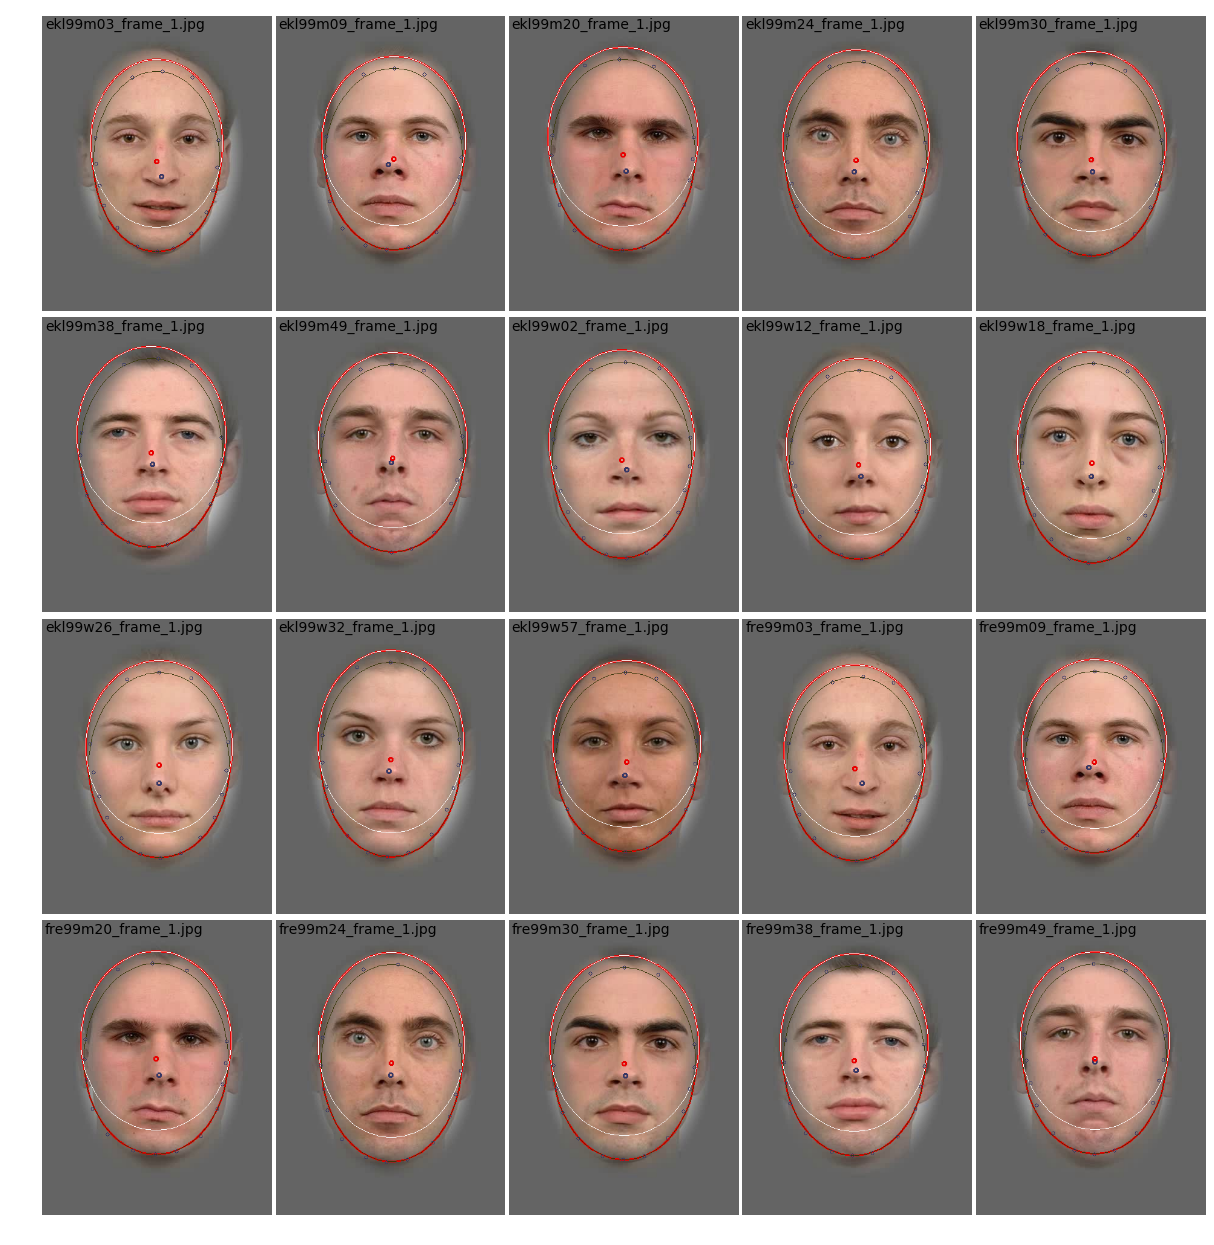

In [440]:
def annotate_face(img='./img/fre99m36_frame_1.jpg', y_offset=50, crop=True):
    im = cv2.imread(img)
    points = locator.face_points(img)
    
    nosetip = points[52]
    left_center_point = points[0]
    right_center_point = points[12]
    chin = points[6]
    forehead_tip = points[14]
    
    width = right_center_point[0] - left_center_point[0] + 5
    center_x = (right_center_point[0] + left_center_point[0]) / 2
    
    height = chin[1] - forehead_tip[1]
    center_y = (chin[1] + forehead_tip[1]) / 2
    
    center = [center_x, center_y]
    
    el_bottom = cv2.ellipse2Poly((center_x, center_y), (width/2, height/2), 0,0,360,4)
    el_top = cv2.ellipse2Poly((center_x, center_y - 30), ((width/2) + 5, (height/2)-10), 0,0,360,4)
    el_total = cv2.convexHull(np.vstack([el_top, el_bottom]))
    
    cv2.polylines(im, [el_total], True, (0,0,233), thickness=2)
    cv2.polylines(im, np.int32([el_bottom]), True, (10,55,55), thickness=1)
    cv2.polylines(im, np.int32([el_top]), True, (255,255,255), thickness=1)
    
    for point in points[0:16]:
        cv2.circle(im, (point[0], point[1]), 3, (100,55,55), thickness=1)
    cv2.circle(im, (nosetip[0], nosetip[1]), 3, (100,55,55), thickness=2)
    cv2.circle(im, (center_x, center_y), 3, (0,0,233), thickness=2)
    
    if crop:
        y, h, x, w = 100, 490, 60, 380
        im = im[y:y+h, x:x+w]
    im = cv2.cvtColor(im, cv2.cv.CV_BGR2RGB)
    
    return im

img_flist = os.listdir('./img')

img = './img/ekl99w12_frame_1.jpg'
im = annotate_face(img)

n_rows = 4
plt.figure(figsize=(15,n_rows*6))
for i in xrange(n_rows*5):
    im_idx = i*3
    im = annotate_face(os.path.join('./img/',img_flist[im_idx]))
    plt.subplot(n_rows,5, i + 1)
    plt.axis('off')
    plt.imshow(im)
    plt.text(4, 20, img_flist[im_idx], fontsize=10)

# adjust whitespace between subplots
left, right, bottom, top = 0.125, 0.9, 0.5, 1
wspace, hspace = 0.02, 0.02
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
    
    

In [ ]:
img_flist = os.listdir('./img')
img_list_pts = []
img_list_pts_smooth = []

for i in xrange(4):
    cur_f = os.path.join('./img', img_flist[i])
    img = draw_points(cur_f, smooth=False)
    img_list_pts.append(img)
    img = draw_points(cur_f, smooth=True)
    img_list_pts_smooth.append(img)
    
    

In [20]:
# stasm: (my left & right ...)
# 0: left edge, eye
# 6: chin (center, lower edge)
# 12: right eye
# 13: upper right boundary
# 14: center forehead?
# 15: upper left boundary?

# 17:27 eybrows. (17:23: left, 23:27: right)
# 30:38: contour left eye
# 38: pupil left
# 39: pupil right
# 40:48: countour right eye
# 48:59 : nose (53: tip?)
# 59:77: mouth
# 77: upper left extra bounding point
# 78: upper right extra bounding point


# ellipse containing the actual image:
y_offset = 50
width_offset = 10
x, y = 511/2, 768/2-y_offset
# weiter
ax1, ax2 = 280, 375
# enger
ax1, ax2 = 275, 370
# fast ohne verlauf
ax1, ax2 = 250, 360

angle = 0
el = cv2.ellipse2Poly((x,y), (ax1/2, ax2/2), 0,0,360,4)

# stasm-points up to eyes
[points_orig[0:13]]
# what we need:
[points_orig[0:16]]

img = './img/fre99m30_frame_1.jpg'
im = cv2.imread(img)
points = locator.face_points(img, add_boundary_points=True)
points_orig = points
points = cv2.convexHull(points)
poly = cv2.approxPolyDP(points, 5, True)
print points_orig.shape
nosetip = points_orig[52]
left_center_point = points_orig[0]
right_center_point = points_orig[12]
chin = points_orig[6]
forehead_tip = points_orig[14]

width = right_center_point[0] - left_center_point[0] + 5
eyes_y = (lpy+rpy)/2
height = chin[1] - forehead_tip[1]
center_y = (chin[1] + forehead_tip[1]) / 2
center_x = nosetip[0]
center = [center_x, center_y]

y_offset = 50
x, y = 511/2, 768/2-y_offset
print "x, y", x, y
ax1, ax2 = 250, 360
angle = 0
el = cv2.ellipse2Poly((center_x, center_y), (width/2, height/2), 0,0,360,4)
el2 = cv2.ellipse2Poly((center_x, center_y - 5), ((width/2) + 10, height/2), 0,0,360,4)

#cv2.drawContours(im, [points_orig[0:15]], -1, (0,255,0),2)
#cv2.polylines(im, np.int32([points_orig[0:18]]), True, (100,55,55), thickness=2)
i = 0

cv2.rectangle(im, (points_orig[15][0], points_orig[15][1] - 17), (points_orig[13][0], \
                                                                  points_orig[13][1]), (0,0,0))

#print points_orig[0:17]
for point in points_orig[0:16]:
    #print point
    cv2.circle(im, (point[0], point[1]), 3, (100,55,55), thickness=2)
    i +=1
cv2.polylines(im, np.int32([el]), True, (10,55,55), thickness=2)
cv2.polylines(im, np.int32([el2]), True, (255,255,255), thickness=2)
cv2.drawContours(im, [points_orig[52:53]], -1, (0,255,0),2)
cv2.circle(im, (center_x, center_y), 2, (0,255,0),2)
y, h, x, w = 100, 490, 60, 380
crop_img = im[y:y+h, x:x+w]
crop_img = cv2.cvtColor(crop_img, cv2.cv.CV_BGR2RGB)
plt.figure(figsize=(8, 8))
plt.imshow(crop_img)
plt.axis('off')
plt.show()

imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray)
#plt.show()
ret,thresh = cv2.threshold(imgray,100,255,cv2.THRESH_BINARY)
plt.imshow(thresh)
#plt.show()
#im2, contours, hierarchy = 
a,b = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
#print b[0]
#print a[[b[0]]]
cnt = a#[0:10]
cv2.drawContours(im, cnt, -1, (0,255,0), 2)
im = cv2.cvtColor(im, cv2.cv.CV_BGR2RGB)
plt.imshow(im)
len(a)

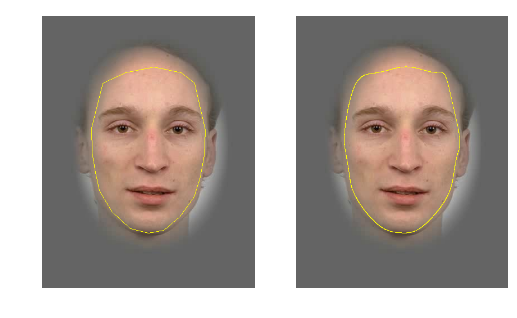

In [21]:
y, h, x, w = 100, 490, 60, 380
crop_img = img_list_pts[0][y:y+h, x:x+w]
img = cv2.cvtColor(crop_img, cv2.cv.CV_BGR2RGB)
crop_img = img_list_pts_smooth[0][y:y+h, x:x+w]
img_smooth = cv2.cvtColor(crop_img, cv2.cv.CV_BGR2RGB)

plt.subplot(121)
plt.axis('off')
plt.imshow(img)
plt.subplot(122)
plt.axis('off')
plt.imshow(img_smooth)


In [38]:
img_flist = os.listdir('./img')
img_list_offs15 = []
img_list_offs5 = []

for i in xrange(4):
    cur_f = os.path.join('./img', img_flist[i])
    img = draw_ellipses(cur_f, pad_x = 5, y_offset=15)
    img_list_offs15.append(img)
    
for i in xrange(4):
    cur_f = os.path.join('./img', img_flist[i])
    img = draw_ellipses(cur_f, pad_x = 10, y_offset=5)
    img_list_offs5.append(img)
    

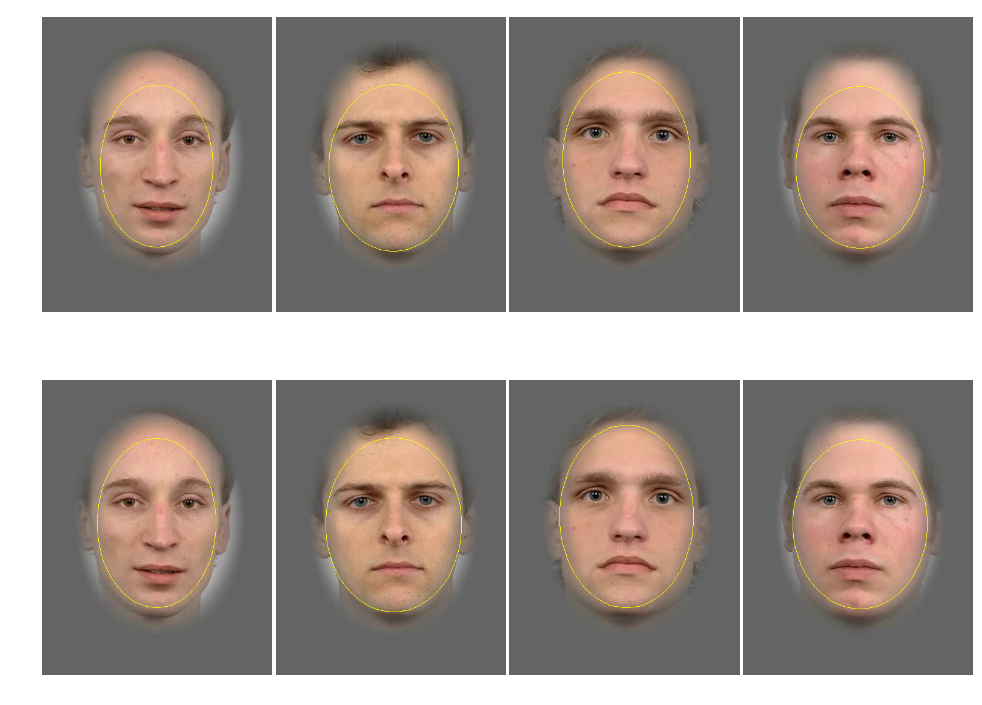

In [47]:
%matplotlib inline
n_images = len(img_list)
width = 12
height = 12
plt.figure(figsize=(width, height))
y, h, x, w = 100, 490, 60, 380

for i in xrange(n_images):
    plt.subplot(2,n_images, i + 1)
    plt.axis('off')
    crop_img = img_list_offs15[i][y:y+h, x:x+w]
    # NOTE: its img[y: y + h, x: x + w] and *not* img[x: x + w, y: y + h]
    img = cv2.cvtColor(crop_img, cv2.cv.CV_BGR2RGB)
    plt.imshow(img)
    
for i in xrange(n_images):
    plt.subplot(2,n_images, i + 5)
    plt.axis('off')
    crop_img = img_list_offs5[i][y:y+h, x:x+w]
    img = cv2.cvtColor(crop_img, cv2.cv.CV_BGR2RGB)
    plt.imshow(img)

    
    
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.3   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.02   # the amount of width reserved for blank space between subplots
hspace = 0.02   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
#plt.show()
#img = cv2.cvtColor(img_cv, cv2.cv.CV_BGR2RGB)
#plt.axis('off')

In [6]:
plt.subplot?

delta = 4 shape ellipse: (91L, 2L)
angle = 178.444030762 but using 0
padded x 15 padded y 20
(768L, 511L)
(79L, 2L)
(77L, 2L)
(768L, 511L, 3L)
(768L, 511L, 4L)


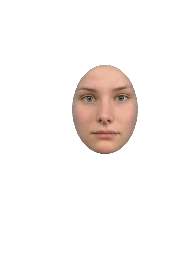

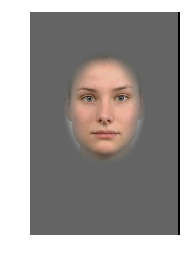

In [25]:
#mask = cv2.blur(mask, (blur_radius, blur_radius))
print mask.shape
print points.shape
#print points
imcv2 = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
img = scipy.ndimage.imread(img)[..., :3]
landmarks = stasm.search_single(imcv2)
print landmarks.shape
#print landmarks
#print points
pointsfl = points.astype('float32')
stasm.force_points_into_image(pointsfl, imcv2)
#print img
imgnew = facemorpher.blender.apply_mask(img, mask)
print imgnew.shape
imgnew_alpha = np.dstack((imgnew, mask))
print imgnew_alpha.shape
plt.axis('off')
plt.imshow(imgnew_alpha)
plt.show()
plt.axis('off')
plt.imshow(img)
plt.show()

In [30]:
import cv2
import numpy as np

def mask_from_points(size, points):
    radius = 10  # kernel size
    kernel = np.ones((radius, radius), np.uint8)

    mask = np.zeros(size, np.uint8)
    cv2.fillConvexPoly(mask, cv2.convexHull(points), 255)
    mask = cv2.erode(mask, kernel)

    return mask



In [36]:
mask = np.zeros(2500, np.uint8)
kernel = np.ones((10, 10), np.uint8)

print cv2.fillConvexPoly(mask, cv2.convexHull(points), 255)
#cv2.convexHull(points)


[0 0 0 ..., 0 0 0]


In [7]:
import os.path
import cv2
import stasm

path = './frame_1.jpg'

img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
img_c = cv2.imread(path)

if img is None:
    print("Cannot load", path)
    raise SystemExit

landmarks = stasm.search_single(img)
#landmarks = stasm.convert_shape(landmarks, stasm.AR)

if len(landmarks) == 0:
    print("No face found in", path)
else:
    landmarks = stasm.force_points_into_image(landmarks, img_c)
    for point in landmarks:
        img[round(point[1])][round(point[0])] = 255

cv2.imshow("stasm minimal", img_c)
cv2.waitKey(0)

TypeError: Image must be a 2D array.